### 1. Preprocessing

In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Importing the dataset

#import breast-cancer-wisconsin.data
df = pd.read_csv('breast-cancer-wisconsin.data', header=None)

# Replace and drop bad values
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

#add column names
df.columns = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

#drop sample code number
df.drop('Sample code number', axis=1, inplace=True)

#change target label
df['Class'] = df['Class'].map({2:0,4:1})


<AxesSubplot:ylabel='count'>

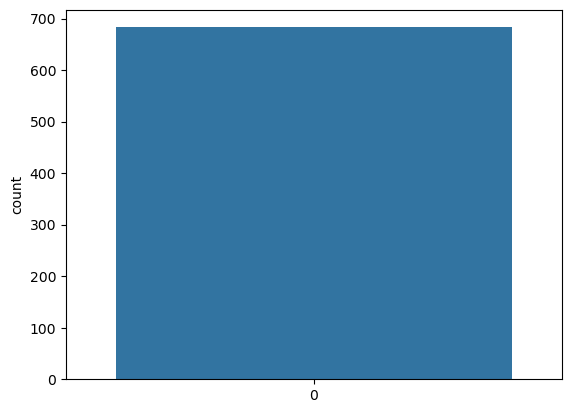

In [28]:
#our class distribution, we can see that we have a class imbalance and we will likely need to account for this in our model and evaluation.


import warnings
warnings.filterwarnings('ignore')

sns.countplot(df['Class'],label="Count")

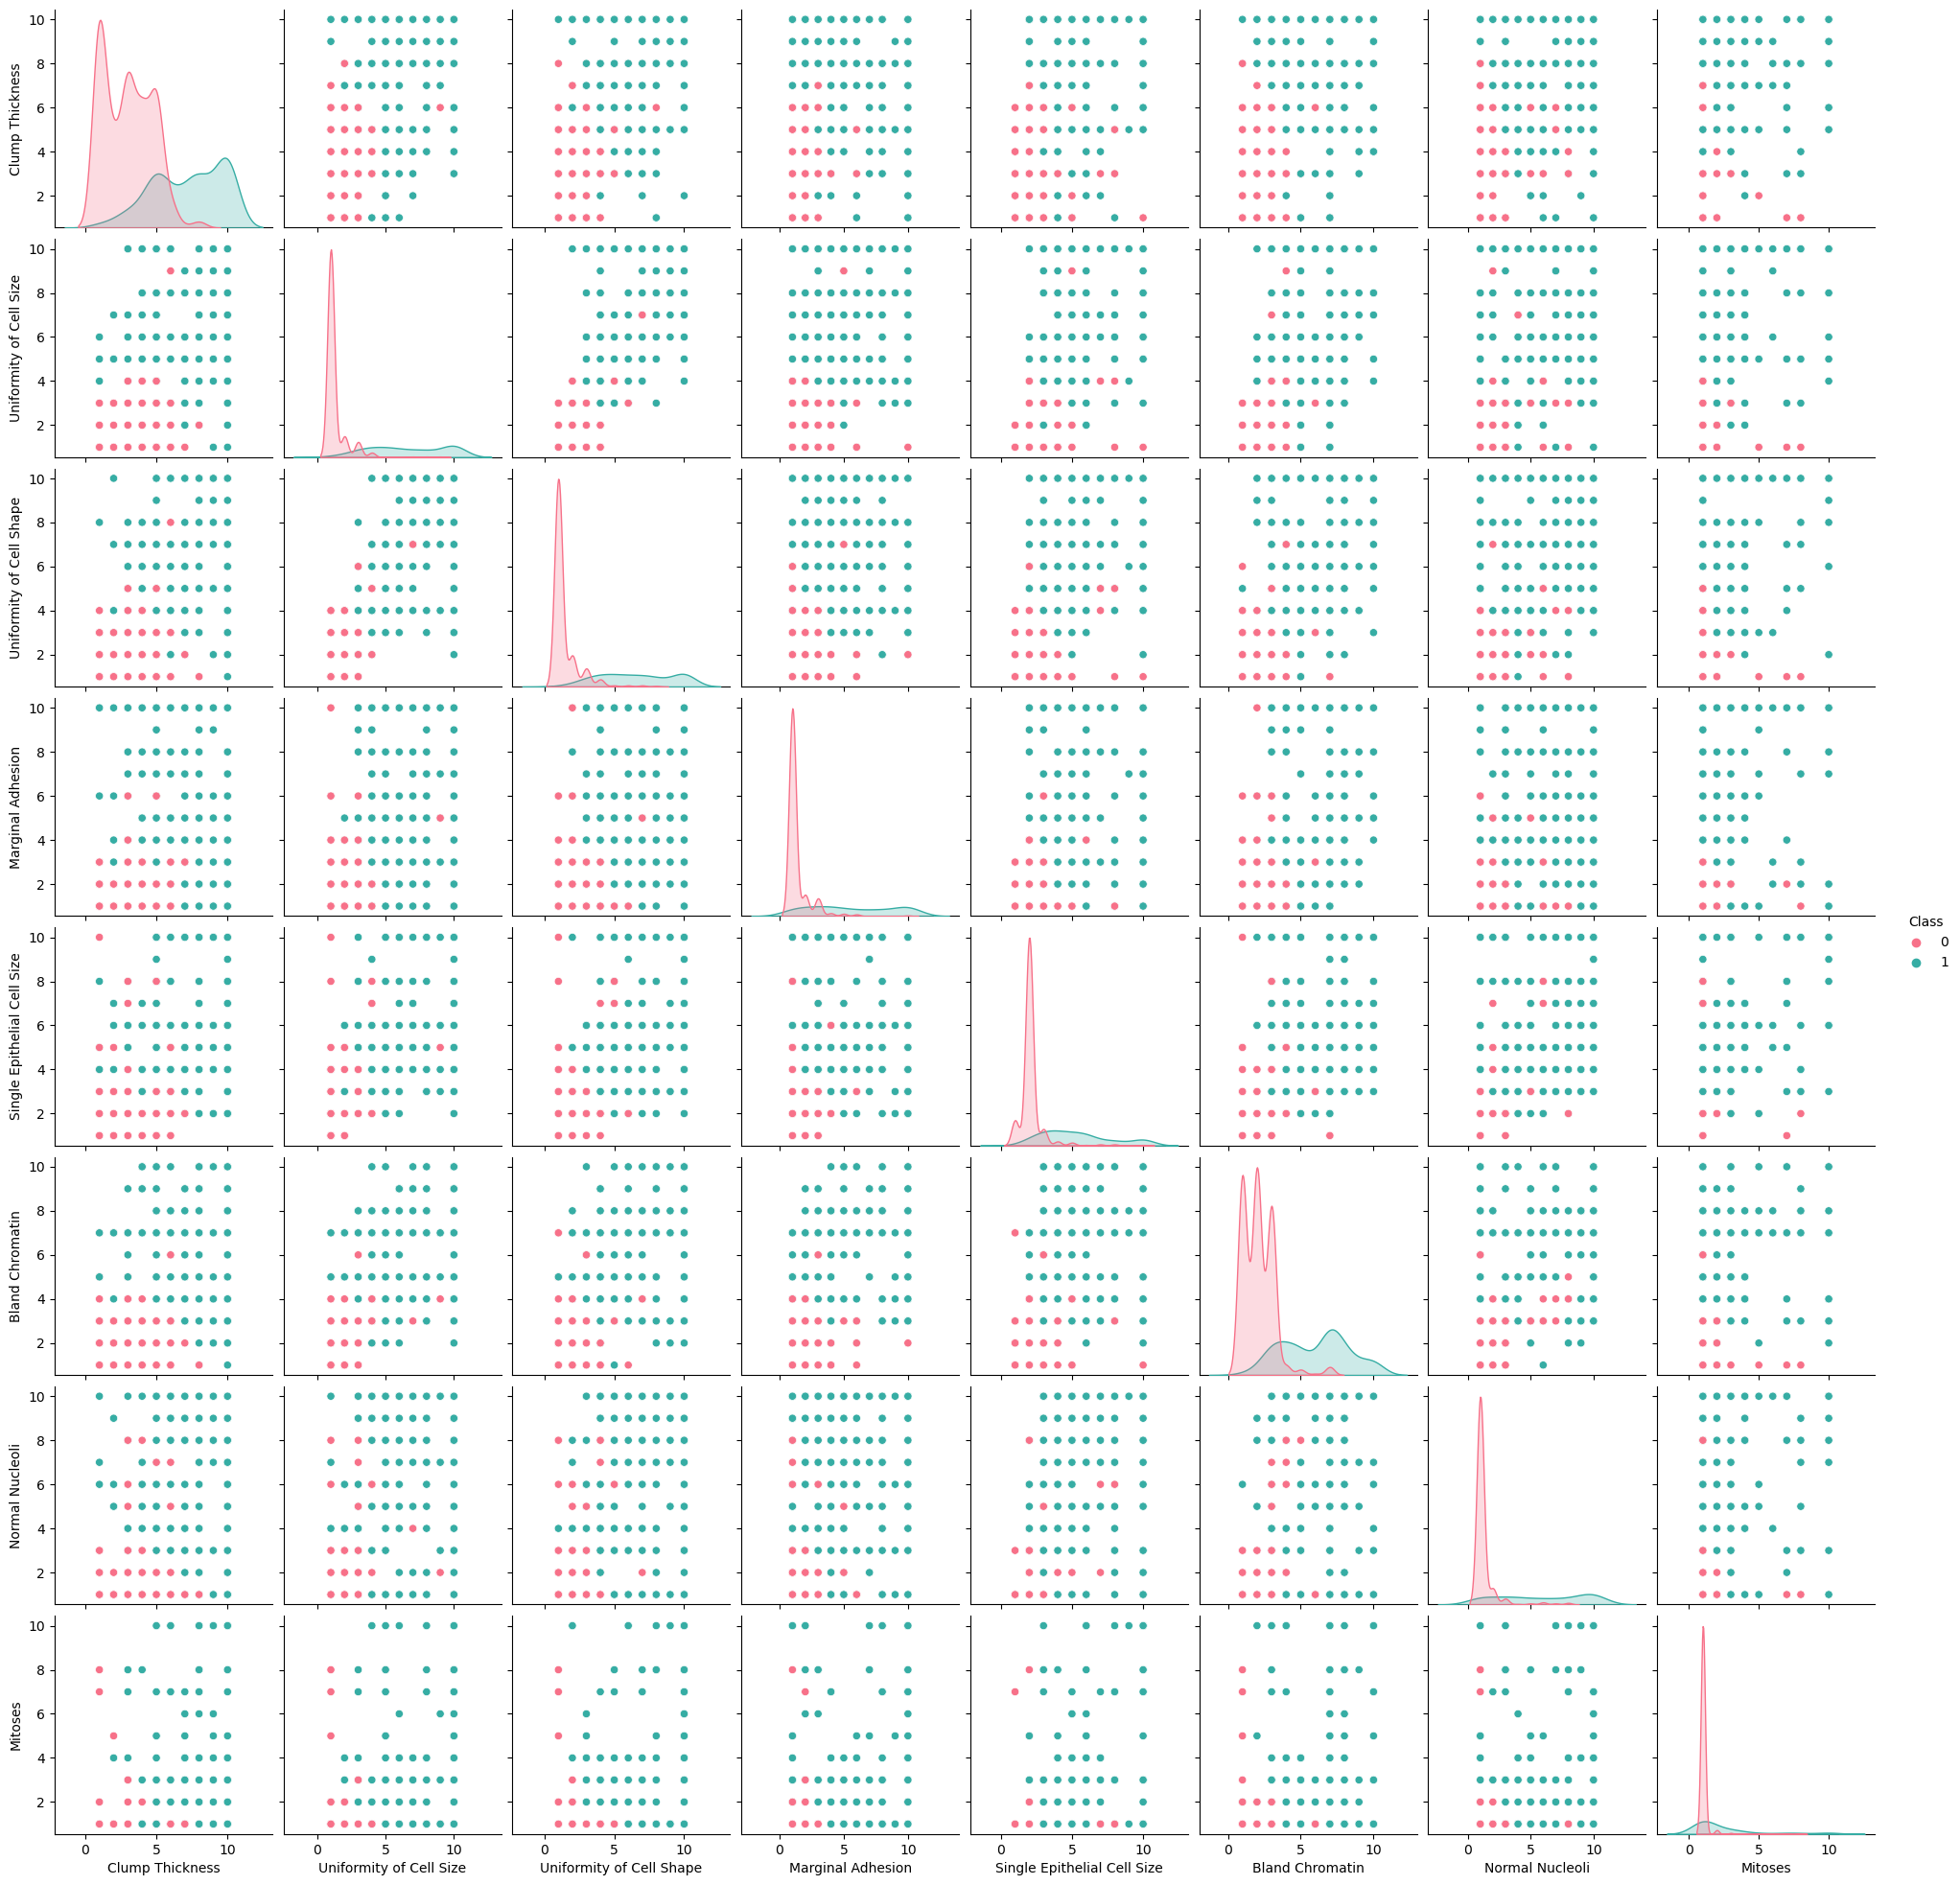

In [29]:
#create scatter plot matrix
sns.pairplot(df, hue='Class', diag_kind = 'kde', palette='husl')

In [30]:
#split data into training, validation and test sets
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)



### 2. Model Training and Evaluation using SVC with a linear kernel

In [31]:
# Fitting training SVM with linear kernel
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)


y_pred = classifier.predict(X_val)


cm = confusion_matrix(y_val, y_pred)
print('linear svm confusion matrix: ', cm)

#in our report we can observe a percent precision in our 0 class with very high accuracy. The recall makes sense because of our class imbalance in the sample set.

print(classification_report(y_val, y_pred))

linear svm confusion matrix:  [[68  0]
 [ 1 41]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.98      0.99        42

    accuracy                           0.99       110
   macro avg       0.99      0.99      0.99       110
weighted avg       0.99      0.99      0.99       110



### 3. Fitting SVM with an rbf kernel

In [32]:
# Fitting training SVM with rbf kernel
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)

cm = confusion_matrix(y_val, y_pred)

#we observe the similar results with the rbf kernel
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.98      0.99        42

    accuracy                           0.99       110
   macro avg       0.99      0.99      0.99       110
weighted avg       0.99      0.99      0.99       110



### 4. Fitting SVM with polynomial kernel

In [33]:

classifier = SVC(kernel = 'poly', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
print(cm)

#our polynomial model performs worse than the linear and rbf models
print(classification_report(y_val, y_pred))

[[68  0]
 [ 5 37]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        68
           1       1.00      0.88      0.94        42

    accuracy                           0.95       110
   macro avg       0.97      0.94      0.95       110
weighted avg       0.96      0.95      0.95       110



### 5. Applying cross validation with our training models

In [34]:
#perform cross fold validation on training set at cv=10
from sklearn.model_selection import cross_val_score

#set classifier to linear
classifier = SVC(kernel = 'linear', random_state = 0)

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("linear Accuracy: {:.2f} %".format(accuracies.mean()*100))

#set classifier to rbf
classifier = SVC(kernel = 'rbf', random_state = 0)

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("RBF Accuracy: {:.2f} %".format(accuracies.mean()*100))

#set classifier to polynomial
classifier = SVC(kernel = 'poly', random_state = 0)

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("Polynomial Accuracy: {:.2f} %".format(accuracies.mean()*100))

#from the result, it can be seen that both linear and RBF kernels perform better than the polynomial kernel

linear Accuracy: 96.33 %
RBF Accuracy: 96.56 %
Polynomial Accuracy: 95.18 %


### 6. Performing Grid Search for the best value of C and the appropriate kernel

In [35]:
#perform grid search on training set
from sklearn.model_selection import GridSearchCV

#set params
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly']}]

#set classifier
classifier = SVC(random_state =69)

#set grid search
grid_search = GridSearchCV(estimator = classifier, param_grid = parameters, scoring = 'accuracy', cv = 10, n_jobs = -1)

In [36]:
grid_search = grid_search.fit(X_train, y_train)

#best accuracy
best_accuracy = grid_search.best_score_

#best params
best_parameters = grid_search.best_params_

print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

#fitting training SVM with best params  {'C': 1, 'kernel': 'linear'}
classifier = SVC(kernel = 'linear', random_state = 0, C=1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_val)

# Making the Confusion Matrix

cm = confusion_matrix(y_val, y_pred)
print(cm)

#calculate report
print(classification_report(y_val, y_pred))

#we achieve a 99 percent accuracy with our linear kernel and C=1

Best Accuracy: 96.56 %
Best Parameters: {'C': 1, 'kernel': 'rbf'}
[[68  0]
 [ 1 41]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.98      0.99        42

    accuracy                           0.99       110
   macro avg       0.99      0.99      0.99       110
weighted avg       0.99      0.99      0.99       110



### 6. Performing final evaluation on test set

In [37]:
#evaluate on test set
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

#calculate report
print(classification_report(y_test, y_pred))

#our model achieves a 96 percent accuracy on the test set

[[83  4]
 [ 2 48]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        87
           1       0.92      0.96      0.94        50

    accuracy                           0.96       137
   macro avg       0.95      0.96      0.95       137
weighted avg       0.96      0.96      0.96       137

